In [5]:
pip install tensorflow scikit-learn matplotlib


   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.1 MB 932.9 kB/s eta 0:00:12
   -- ------------------------------------- 0.8/11.1 MB 1.0 MB/s eta 0:00:10
   -- ------------------------------------- 0.8/11.1 MB 1.0 MB/s eta 0:00:10
   -- ------------------------------------- 0.8/11.1 MB 1.0 MB/s eta 0:00:10
   -- ------------------------------------- 0.8/11.1 MB 1.0 MB/s eta 0:00:10
   -- ------------------------------------- 0.8/11.1 MB 1.0 MB/s eta 0:00:10
   --- ------------------------------------ 1.0/11.1 MB 553.0 kB/s eta 0:00:19
   --- ------------------------------------ 1.0/11.1 MB 553.0 kB/s eta 0:00:19
   ---- ----------------------------------- 1.3/11.1 MB 512.2 kB/s eta 0:00:20
   ---- ----------------------------------- 1.3/11.1 MB 512.2 kB/s eta 0:00:20
   ----- -

In [6]:
pip install ipykernel


Note: you may need to restart the kernel to use updated packages.


In [9]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# ---- 1. CONFIGURATION ---- #
DATASET_DIR = "C:/Users/Mallik/Desktop/plant_diagnosis_backend/dataset"  # Change to your path
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
MODEL_SAVE_PATH = "C:/Users/Mallik/Desktop/plant_diagnosis_backend/model"

# ---- 2. LOAD DATA ---- #
train_ds = image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

# ---- 3. PREFETCH & CACHE ---- #
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ---- 4. DATA AUGMENTATION ---- #
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# ---- 5. MODEL (TRANSFER LEARNING) ---- #
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False  # Freeze base model

model = models.Sequential([
    data_augmentation,
    layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input),  # ✅ Wrap the preprocess function
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# ---- 6. TRAIN MODEL ---- #
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# ---- 7. SAVE MODEL ---- #
model.save(MODEL_SAVE_PATH)
print(f"✅ Model saved to: {MODEL_SAVE_PATH}")

# ---- 8. PLOT TRAINING HISTORY ---- #
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ---- 9. EVALUATE PERFORMANCE ---- #
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("📊 Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
print("🧮 Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


Found 1609 files belonging to 10 classes.
Using 1288 files for training.
Found 1609 files belonging to 10 classes.
Using 321 files for validation.
Class names: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.2931 - loss: 2.1295 - val_accuracy: 0.4860 - val_loss: 1.4187
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.5627 - loss: 1.2798 - val_accuracy: 0.5857 - val_loss: 1.1563
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.5963 - loss: 1.0607 - val_accuracy: 0.6106 - val_loss: 1.0375
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.6434 - loss: 1.0030 - val_accuracy: 0.6293 - val_loss: 1.0191
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7322 - loss: 0.7940 - val_accuracy: 0.6044 - val_loss: 1.0360
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6566 - loss: 0.8819 - val_accuracy: 0.6417 - val_loss: 0.9559
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7192 - loss: 0.7683 - val_accuracy: 0.6667 - val_loss: 0.9052
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7480 - loss: 0.7240 - val_accuracy: 0.6636 - val_los

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=C:/Users/Mallik/Desktop/plant_diagnosis_backend/model.

In [9]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# ---- 1. CONFIGURATION ---- #
DATASET_DIR = "C:/Users/Mallik/Desktop/plant_diagnosis_backend/dataset"  # Change to your path
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
MODEL_SAVE_PATH = "C:/Users/Mallik/Desktop/plant_diagnosis_backend/model"

# ---- 2. LOAD DATA ---- #
train_ds = image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

# ---- 3. PREFETCH & CACHE ---- #
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ---- 4. DATA AUGMENTATION ---- #
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# ---- 5. MODEL (TRANSFER LEARNING) ---- #
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False  # Freeze base model

model = models.Sequential([
    data_augmentation,
    layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input),  # ✅ Wrap the preprocess function
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# ---- 6. TRAIN MODEL ---- #
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# ---- 7. SAVE MODEL ---- #
model.save(MODEL_SAVE_PATH)
print(f"✅ Model saved to: {MODEL_SAVE_PATH}")

# ---- 8. PLOT TRAINING HISTORY ---- #
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ---- 9. EVALUATE PERFORMANCE ---- #
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("📊 Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
print("🧮 Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


Found 1609 files belonging to 10 classes.
Using 1288 files for training.
Found 1609 files belonging to 10 classes.
Using 321 files for validation.
Class names: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.2931 - loss: 2.1295 - val_accuracy: 0.4860 - val_loss: 1.4187
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.5627 - loss: 1.2798 - val_accuracy: 0.5857 - val_loss: 1.1563
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.5963 - loss: 1.0607 - val_accuracy: 0.6106 - val_loss: 1.0375
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.6434 - loss: 1.0030 - val_accuracy: 0.6293 - val_loss: 1.0191
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7322 - loss: 0.7940 - val_accuracy: 0.6044 - val_loss: 1.0360
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6566 - loss: 0.8819 - val_accuracy: 0.6417 - val_loss: 0.9559
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7192 - loss: 0.7683 - val_accuracy: 0.6667 - val_loss: 0.9052
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7480 - loss: 0.7240 - val_accuracy: 0.6636 - val_los

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=C:/Users/Mallik/Desktop/plant_diagnosis_backend/model.

Found 1609 files belonging to 10 classes.
Using 1288 files for training.
Found 1609 files belonging to 10 classes.
Using 321 files for validation.
✅ Class names: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_2 (Lambda)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.2479 - loss: 2.2362 - val_accuracy: 0.5016 - val_loss: 1.4394
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.5457 - loss: 1.3376 - val_accuracy: 0.5670 - val_loss: 1.2621
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.6133 - loss: 1.0897 - val_accuracy: 0.5794 - val_loss: 1.1509
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6678 - loss: 0.9059 - val_accuracy: 0.5950 - val_loss: 1.0815
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6783 - loss: 0.8816 - val_accuracy: 0.6044 - val_loss: 1.0235
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.7196 - loss: 0.8541 - val_accuracy: 0.6262 - val_loss: 0.9969
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7138 - loss: 0.8043 - val_accuracy: 0.6449 - val_loss: 0.9575
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.6866 - loss: 0.7831 - val_accuracy: 0.6168 - val_los

✅ Model saved to: C:/Users/Mallik/Desktop/plant_diagnosis_backend/model.h5


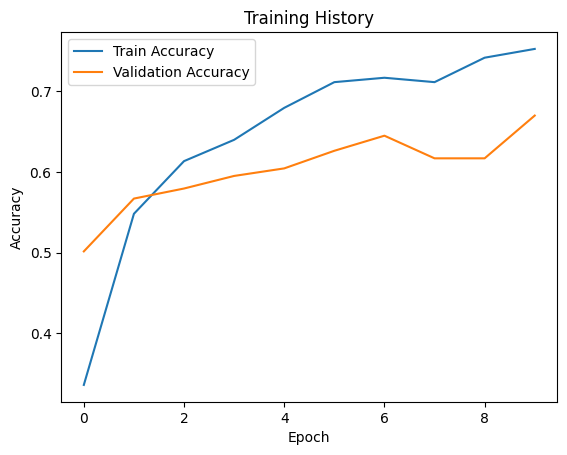

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
📊 Classification Report:
                                                precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.75      0.57      0.65        21
                        Tomato___Early_blight       0.56      0.61      0.58        51
                         Tomato___Late_blight       0.81      0.62      0.70        34
                           Tomato___Leaf_Mold       0.64      0.78      0.70        79
                  Tomato___Septoria_leaf_spot       0.56      0.90      0.69        20
Tomato___Spider_mites Two-spotted_spider_mite       0.5

In [10]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# ---- 1. CONFIGURATION ---- #
DATASET_DIR = "C:/Users/Mallik/Desktop/plant_diagnosis_backend/dataset"  # Change this to your dataset path
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
MODEL_SAVE_PATH = "C:/Users/Mallik/Desktop/plant_diagnosis_backend/model.h5"  # ✅ Save as .h5 format

# ---- 2. LOAD DATA ---- #
train_ds = image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print(f"✅ Class names: {class_names}")

# ---- 3. PREFETCH & CACHE ---- #
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ---- 4. DATA AUGMENTATION ---- #
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# ---- 5. MODEL (TRANSFER LEARNING) ---- #
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input),  # ✅ preprocessing wrapped in Lambda
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# ---- 6. TRAIN MODEL ---- #
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# ---- 7. SAVE MODEL (.h5 format) ---- #
model.save(MODEL_SAVE_PATH)
print(f"✅ Model saved to: {MODEL_SAVE_PATH}")

# ---- 8. PLOT TRAINING HISTORY ---- #
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ---- 9. EVALUATE PERFORMANCE ---- #
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("📊 Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
print("🧮 Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
